# Simulating Bayesian Reinforcement Learning


Simulated example to illustrate the success of the methodology.

----
```
author:    Zach Wolpe
email:     zachcolinwolpe@gmail.com
reviewer:  na
date:      03 January 2022
```
----



# Simulated Experiment

### Model 

Out $action \ space$ consists of $3$ options:

$$A:a\in\{c,s,n\}$$


### Data Generating Process

Arificially assume that:

$$\alpha = 0.4, \beta=7$$

We are absolute to simulated a dataset that captures this DGP.

Rewards are encoded in binary:

$$
r_t =
\begin{cases}
  & 1, \text{ if } a_t \text{ is correct } \\
  & 0, \text{ otherwise}
\end{cases}
$$


Initially we assume that the state values are stationary, with the probability of recieving a reward at each state being:

$$
Pr(r_t=1|Q_t(a)) = \begin{cases}
  & 0.8 \text{  if } a=c \\
  & 0.6 \text{  if } a=s \\
  & 0.7 \text{  if } a=n
\end{cases}
$$


***Given these parameters we can simulate choice behaviour.***

Initialize $t=0$ them all with equal probability:

$$Q_0(a)=\frac{1}{3} \ ∀ \ a\in \{c,s,n\}$$

Thereafter, the state space approximations are updated when an action is taken & feedback is recieved:

$$Q_t(a) = Q_{t-1}(a) + \alpha \left[ r_t - Q_{t-1}(a) \right]
$$



The state-space approximations are used to sample actions probabilistically in a multinomial fashion, following a Bolzmann distribution:


$$\pi_t(a) = \frac{exp \; \beta Q_t(a) }{ \sum_{a} 
exp \; \beta \ Q_t(a) 
}
$$

```
author:      Zach Wolpe
email:       zach.wolpe@medibio.com.au
reviewer:    n/a
date:        01 Jan 2022
```

In [1]:
%%capture
!pip upgrade arviz==0.6.1

In [ ]:
!pip install git+https://github.com/pymc-devs/pymc3
!pip install git+git://github.com/arviz-devs/arviz.git

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from tqdm import tqdm
import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az

In [5]:
def data_generating_process(alpha, beta, n=100, p_r=[.8, .6, .7]):
  actions = np.zeros(n, dtype=np.int)
  rewards = np.zeros(n, dtype=np.int)
  Qs      = np.zeros((n, 3))

  # Q init
  Q = np.array(len(p_r)*[1/len(p_r)])

  for i in tqdm(range(n)):
    # P(a|Q): Apply Boltzmann distribution
    exp_Q = np.exp(beta*Q)
    pi_a  = exp_Q / np.sum(exp_Q)


    # Simulate action-reward
    a = np.random.choice([0,1,2], p=pi_a)
    r = np.random.rand() < p_r[a]

    # Update Qt(a) = Qt-1(a) + a[RPE]
    Q[a] = Q[a] + alpha * (r - Q[a])

    # store
    actions[i] = a
    rewards[i] = r
    Qs[i] = Q.copy()

  return actions, rewards, Qs  

In [24]:
true_alpha  = .40
true_beta   = 10
n           = 100
actions, rewards, Qs = data_generating_process(alpha=true_alpha, beta=true_beta, n=n)

/var/folders/kd/p1z7_f_974d7tkw1zmvskn_m0000gn/T/ipykernel_20269/1437380353.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  actions = np.zeros(n, dtype=np.int)
/var/folders/kd/p1z7_f_974d7tkw1zmvskn_m0000gn/T/ipykernel_20269/1437380353.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curre

In [25]:
def plot_data(actions, rewards, Qs):
    plt.figure(figsize=(30,3))
    x = np.arange(len(actions))

    plt.plot(x, Qs[:, 0] - .5 + 0, c='C0', lw=3, alpha=.3)
    plt.plot(x, Qs[:, 1] - .5 + 1, c='C1', lw=3, alpha=.3)
    plt.plot(x, Qs[:, 2] - .5 + 2, c='C2', lw=3, alpha=.3)

    s   = 50
    lw  = 2

    # action = 0
    cond = (actions == 0) & (rewards == 0)
    plt.scatter(x[cond], actions[cond], s=s, c='None', ec='C0', lw=lw)

    cond = (actions == 0) & (rewards == 1)
    plt.scatter(x[cond], actions[cond], s=s, c='C0', ec='C0', lw=lw)

    # action = 1
    cond = (actions == 1) & (rewards == 0)
    plt.scatter(x[cond], actions[cond], s=s, c='None', ec='C1', lw=lw)

    cond = (actions == 1) & (rewards == 1)
    plt.scatter(x[cond], actions[cond], s=s, c='C1', ec='C1', lw=lw)

    # action = 2
    cond = (actions == 2) & (rewards == 0)
    plt.scatter(x[cond], actions[cond], s=s, c='None', ec='C2', lw=lw)

    cond = (actions == 2) & (rewards == 1)
    plt.scatter(x[cond], actions[cond], s=s, c='C2', ec='C2', lw=lw)


    # provide legend 
    plt.scatter(0, 40, c='k', s=s, lw=lw, label='Reward')
    plt.scatter(0, 20, c='w', ec='k', s=s, lw=lw, label='No reward')
    plt.plot([0,1], [20,20], c='k', lw=3, alpha=.3, label='Qvalue (centered)')


    # axes
    plt.yticks([0,1,2], ['colour', 'shape', 'number'])
    plt.ylim(-1, 3)
    plt.ylabel('action: matching rule')
    plt.xlabel('trial')

    # legend
    handles, labels = plt.gca().get_legend_handles_labels()
    order   = (1,2,0)
    handles = [handles[idx] for idx in order]
    labels  = [labels[idx]  for idx in order]

    plt.legend(handles, labels, fontsize=20, loc=(1.01, .27))
    plt.tight_layout()

/var/folders/kd/p1z7_f_974d7tkw1zmvskn_m0000gn/T/ipykernel_20269/1437380353.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  actions = np.zeros(n, dtype=np.int)
/var/folders/kd/p1z7_f_974d7tkw1zmvskn_m0000gn/T/ipykernel_20269/1437380353.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curre

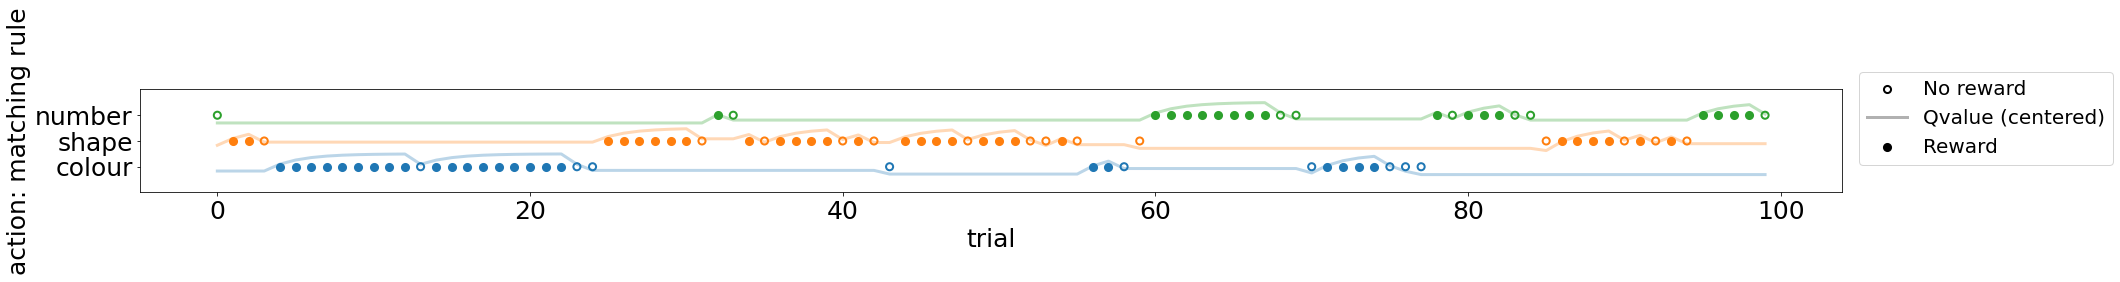

In [38]:
# instantiate
true_alpha              = .40
true_beta               = 10
n                       = 100
actions, rewards, Qs    = data_generating_process(alpha=true_alpha, beta=true_beta, n=n)

# plot 
plt.rcParams.update({'font.size': 25})
plot_data(actions, rewards, Qs)

# PyMC3

In [ ]:
rewards[0:5], actions[0:5]

(array([0, 0, 0, 0, 1]), array([0, 1, 2, 0, 2]))

In [ ]:
def update_Q(action, reward,
             Qs,
             alpha):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by theano.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the theano.scan fn argument:
        fn=lamba action, reward, Qs, alpha: tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """

    Qs = tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    return Qs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 111 seconds.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.


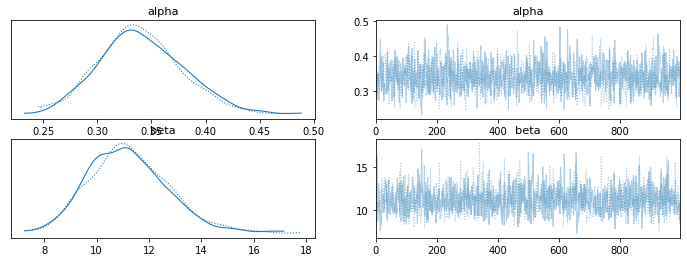

In [ ]:
# model ==========

with pm.Model() as bayesian_reinforcement_learning:

  # data
  actions_  = pm.Data('actions', actions)
  rewards_  = pm.Data('rewards', rewards)

  # priors
  alpha = pm.Beta('alpha', 1, 1)
  beta  = pm.HalfNormal('beta', 10)
  # beta=8
    

  # model 
  # init Qs
  Qs = 0.3333 * tt.ones(3, dtype='float64')

  # Compute the Q values for each trial
  Qs, _ = theano.scan(
      fn=update_Q,
      sequences=[actions_, rewards_],
      outputs_info=[Qs],
      non_sequences=[alpha])


  BQs = beta*Qs
  pi =  tt.nnet.softmax(BQs)
  like = pm.Categorical('like', p=pi, observed=actions_)

  # opt
  trace = pm.sample(tune=1000, chains=2, target_accept=0.85) # tune=5000, target_accept=0.9 njobs=4 ,target_accept=0.99
  idata = az.from_pymc3(trace)
  pm.traceplot(idata)


In [ ]:
display(az.summary(trace, round_to=2))

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.34,0.04,0.26,0.41,0.00,0.00,1438.55,1249.10,1.0
beta,11.22,1.52,8.34,13.89,0.04,0.03,1400.47,1208.37,1.0


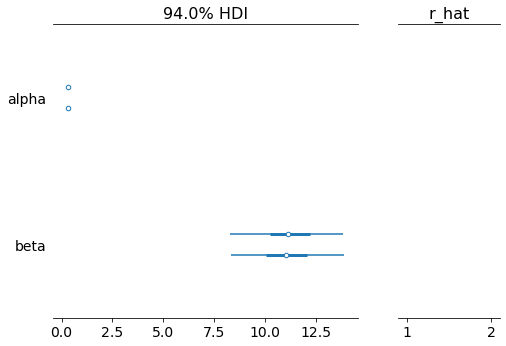

In [ ]:
az.plot_forest(idata, r_hat=True);

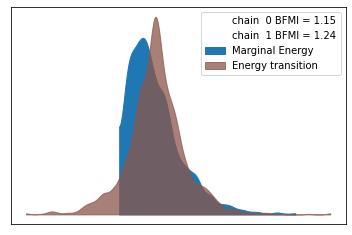

In [ ]:
az.plot_energy(idata);

Text(0.5, 1.0, 'Kernel Density Estimation')

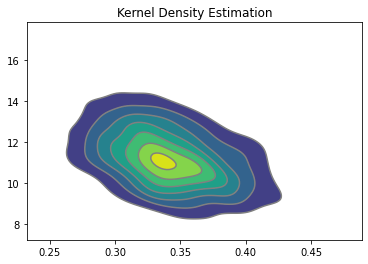

In [ ]:
plt.figure()
# trace = approx.sample(10000)
az.plot_kde(trace["alpha"], trace["beta"])
plt.title('Kernel Density Estimation')

# Sensitivity Analysis ********************************************************

Assessing the reliability of methodolgy over a range of parameters.

In [ ]:

store_results = {}
ii = 0 
for true_alpha in [0.05, 0.1, 0.25, 0.5, 0.75, 1]:
  for true_beta in np.arange(1,11):

    # generate data ============================================================
    actions, rewards, Qs = data_generating_process(alpha=true_alpha, beta=true_beta, n=100)

    # compute model ============================================================
    with pm.Model() as bayesian_reinforcement_learning:

      # data
      actions_  = pm.Data('actions', actions)
      rewards_  = pm.Data('rewards', rewards)

      # priors
      alpha = pm.Beta('alpha', 1, 1)
      beta  = pm.HalfNormal('beta', 10)
      # beta=8

      # model 
      # init Qs
      Qs = 1/3 * tt.ones(3, dtype='float64')

      # Compute the Q values for each trial
      Qs, _ = theano.scan(
          fn=update_Q,
          sequences=[actions_, rewards_],
          outputs_info=[Qs],
          non_sequences=[alpha])

      BQs = beta*Qs
      pi =  tt.nnet.softmax(BQs)
      like = pm.Categorical('like', p=pi, observed=actions_)

      # opt
      trace = pm.sample(tune=1000, chains=2, target_accept=0.85) # tune=5000, target_accept=0.9 njobs=4 ,target_accept=0.99
      idata = az.from_pymc3(trace)
      # pm.traceplot(idata)
    
    # save results =============================================================
    ii += 1
    store_results['idx_' + str(ii)] = {'true_alpha':true_alpha, 'true_beta':true_beta, 'alpha_mean':trace['alpha'].mean(), 'beta_mean':trace['beta'].mean(), 'trace': trace,}



100%|██████████| 100/100 [00:00<00:00, 12639.16it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 88 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 100/100 [00:00<00:00, 10697.57it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 96 seconds.
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 100/100 [00:00<00:00, 11721.83it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 76 seconds.
The acceptance probability does not match the target. It is 0.7595171268069169, but should be close to 0.85. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 100/100 [00:00<00:00, 10063.59it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.
100%|██████████| 100/100 [00:00<00:00, 11900.09it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 81 seconds.
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 100/100 [00:00<00:00, 6216.55it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 89 seconds.
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 100/100 [00:00<00:00, 9469.24it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 58 seconds.
100%|██████████| 100/100 [00:00<00:00, 8601.05it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
100%|██████████| 100/100 [00:00<00:00, 11901.77it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.
100%|██████████| 100/100 [00:00<00:00, 13621.85it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 53 seconds.
100%|██████████| 100/100 [00:00<00:00, 10995.11it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 74 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7774656409327274, but should be close to 0.85. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 100/100 [00:00<00:00, 12892.46it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 88 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 100/100 [00:00<00:00, 11195.26it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 78 seconds.
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 100/100 [00:00<00:00, 13233.75it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 68 seconds.
100%|██████████| 100/100 [00:00<00:00, 9071.51it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 53 seconds.
100%|██████████| 100/100 [00:00<00:00, 5877.59it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
100%|██████████| 100/100 [00:00<00:00, 6444.15it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 70 seconds.
100%|██████████| 100/100 [00:00<00:00, 12401.48it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.
100%|██████████| 100/100 [00:00<00:00, 8952.05it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
100%|██████████| 100/100 [00:00<00:00, 10649.50it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 57 seconds.
100%|██████████| 100/100 [00:00<00:00, 9656.29it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 100 seconds.
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 100/100 [00:00<00:00, 13722.57it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 83 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 100/100 [00:00<00:00, 11685.58it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 72 seconds.
100%|██████████| 100/100 [00:00<00:00, 9772.83it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
100%|██████████| 100/100 [00:00<00:00, 9720.96it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 87 seconds.
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 100/100 [00:00<00:00, 11209.92it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 52 seconds.
100%|██████████| 100/100 [00:00<00:00, 9334.78it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
100%|██████████| 100/100 [00:00<00:00, 10271.09it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 53 seconds.
100%|██████████| 100/100 [00:00<00:00, 12744.00it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 52 seconds.
100%|██████████| 100/100 [00:00<00:00, 8821.76it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 50 seconds.
100%|██████████| 100/100 [00:00<00:00, 10459.09it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 71 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 100/100 [00:00<00:00, 11740.86it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 64 seconds.
The acceptance probability does not match the target. It is 0.7657316885407306, but should be close to 0.85. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 100/100 [00:00<00:00, 10955.76it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 66 seconds.
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 100/100 [00:00<00:00, 10413.13it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.
100%|██████████| 100/100 [00:00<00:00, 12273.74it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 62 seconds.
100%|██████████| 100/100 [00:00<00:00, 11657.64it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 59 seconds.
100%|██████████| 100/100 [00:00<00:00, 9372.12it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
100%|██████████| 100/100 [00:00<00:00, 10436.45it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
100%|██████████| 100/100 [00:00<00:00, 10445.28it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 54 seconds.
100%|██████████| 100/100 [00:00<00:00, 12367.11it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
100%|██████████| 100/100 [00:00<00:00, 10386.05it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 83 seconds.
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 100/100 [00:00<00:00, 10210.34it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
100%|██████████| 100/100 [00:00<00:00, 9055.26it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 66 seconds.
100%|██████████| 100/100 [00:00<00:00, 12269.07it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 67 seconds.
100%|██████████| 100/100 [00:00<00:00, 17777.75it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


In [ ]:
pm.model_to_graphviz(bayesian_reinforcement_learning)

In [ ]:
# Save!
store = store_results.copy()

In [ ]:
with open('store_results.pkl', 'wb') as fid:
     pickle.dump(store_results, fid)

In [ ]:
import pickle
data_org = { 'a':'A', 'b':2, 'c':3.0 } 
data_string = pickle.dumps(data_org)
print('PICKLE:', data_string )

In [ ]:
with open('pickled_data_file.pkl', 'wb') as fid:
     pickle.dump(data_org, fid)

In [ ]:
import plotly.express as px

In [ ]:
true_alpha_means    = []
true_beta_means     = []
approx_alpha_means  = []
approx_beta_means   = []

for idx in tqdm(store_results.keys()):

  true_alpha_means.append(store_results[idx]['true_alpha'])
  true_beta_means.append(store_results[idx]['true_beta'])
  approx_alpha_means.append(store_results[idx]['alpha_mean'])
  approx_beta_means.append(store_results[idx]['beta_mean'])



In [ ]:
import pandas as pd

In [ ]:
data = pd.DataFrame({'true_alpha_means':true_alpha_means,
'true_beta_means':true_beta_means,
'approx_alpha_means':approx_alpha_means,
'approx_beta_means':approx_beta_means})

In [ ]:
data.head()

In [ ]:
fig = px.scatter(data, x='true_alpha_means', y='approx_alpha_means', template='none', title='Alpha')

fig.add_shape(type="line",
              y0=min(data.approx_alpha_means),
              y1=max(data.approx_alpha_means), 
              x0=min(data.true_alpha_means),
              x1=max(data.true_alpha_means),

    line=dict(
        color="steelblue",
        width=2,
        dash="dot",
    ))

fig.update_layout(
    xaxis_title="true alpha",
    yaxis_title="approx alpha",
)

fig.show()

In [ ]:
# px.scatter(data.true_alpha_means, y=data.approx_alpha_means, template='none', title='Alpha')
fig = px.scatter(data, x='true_beta_means', y='approx_beta_means', template='none', title='Beta')

fig.add_shape(type="line",
              y0=min(true_beta),
              y1=max(true_beta), 
              x0=min(true_beta),
              x1=max(true_beta),

    line=dict(
        color="steelblue",
        width=2,
        dash="dot",
    ))

fig.update_layout(
    xaxis_title="true beta",
    yaxis_title="approx beta",
)

fig.show()

# Additional Notes & Appendix

In [ ]:
# Multinomial Logit ================================================================================================================================================================
# source: https://discourse.pymc.io/t/multivariate-multinomial-logistic-regression/5242/2
from sklearn.preprocessing import LabelEncoder, Normalizer, StandardScaler
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
data = datasets.load_iris()
data['target']
data['data']

# data['TYPE']= LabelEncoder().fit_transform(data['TYPE'])
# y_obs = data['TYPE'].values
# x_n = data.columns[:-1]
# x = data[x_n].values

y_obs = data['target']
x = StandardScaler().fit_transform(data['data'])
ndata   = x.shape[0]
nparam  = x.shape[1]
nclass  = len(np.unique(y_obs))

print( y_obs.shape, x.shape )


with pm.Model() as hazmat_model:
    # data
    X_data      = pm.Data('X_data', x)
    y_obs_data  = pm.Data('y_obs_data', y_obs)

    # priors
    alfa        = pm.Normal('alfa', mu=0, sd=1, shape=nclass)
    beta        = pm.Normal('beta', mu=0, sd=1, shape=(nparam, nclass))
    
    
    # model
    mu    = tt.dot(X_data, beta) + alfa
    p     = tt.nnet.softmax(mu)
    yl    = pm.Categorical('obs', p=p, observed=y_obs_data)
    trace = pm.sample()
    idata = az.from_pymc3(trace)
    pm.traceplot(idata)

with hazmat_model:
    pm.set_data({'X_data':np.random.normal(size=(8, 4))})
    pred = pm.fast_sample_posterior_predictive(trace)
# Multinomial Logit ================================================================================================================================================================


In [ ]:
az.plot_posterior(idata);

In [ ]:
az.plot_forest(idata, r_hat=True);

In [ ]:
az.plot_posterior(idata);
